# Deep Recurrent Q-Network 
This notebook provides an example implementation of a Deep Recurrent Q-Network which can solve Partially Observable Markov Decision Processes. To learn more about DRQNs, see my blog post on them here: https://medium.com/p/68463e9aeefc .

For more reinforcment learning tutorials, as well as the additional required `gridworld.py` and `helper.py` see:
https://github.com/awjuliani/DeepRL-Agents

In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
import csv
import itertools
import tensorflow.contrib.slim as slim
%matplotlib inline

from helper2 import *

### Load the game environment

In [2]:
from gridworld import gameEnv

Feel free to adjust the size of the gridworld. Making it smaller (adjusting `size`) provides an easier task for our DRQN agent, while making the world larger increases the challenge.

Initializing the Gridworld with `True` limits the field of view, resulting in a partially observable MDP. Initializing it with `False` provides the agent with the entire environment, resulting in a fully MDP.

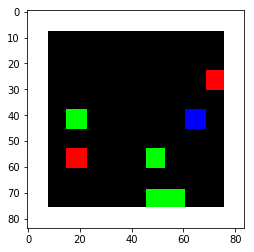

In [3]:
env = gameEnv(partial=False,size=9)

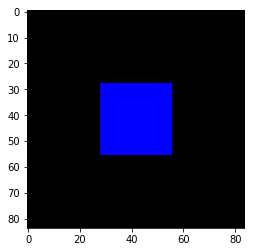

In [4]:
env = gameEnv(partial=True,size=9)

Above are examples of a starting environment in our simple game. The agent controls the blue square, and can move up, down, left, or right. The goal is to move to the green squares (for +1 reward) and avoid the red squares (for -1 reward). When the agent moves through a green or red square, it is randomly moved to a new place in the environment.

### Implementing the network itself

In [5]:
class Qnetwork():
    def __init__(self,h_size,rnn_cell,myScope):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.convolution2d( \
            inputs=self.imageIn,num_outputs=32,\
            kernel_size=[8,8],stride=[4,4],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv1')
        self.conv2 = slim.convolution2d( \
            inputs=self.conv1,num_outputs=64,\
            kernel_size=[4,4],stride=[2,2],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv2')
        self.conv3 = slim.convolution2d( \
            inputs=self.conv2,num_outputs=64,\
            kernel_size=[3,3],stride=[1,1],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv3')
        self.conv4 = slim.convolution2d( \
            inputs=self.conv3,num_outputs=h_size,\
            kernel_size=[7,7],stride=[1,1],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv4')
        
        self.trainLength = tf.placeholder(dtype=tf.int32)
        #We take the output from the final convolutional layer and send it to a recurrent layer.
        #The input must be reshaped into [batch x trace x units] for rnn processing, 
        #and then returned to [batch x units] when sent through the upper levles.
        self.batch_size = tf.placeholder(dtype=tf.int32,shape=[])
        self.convFlat = tf.reshape(slim.flatten(self.conv4),[self.batch_size,self.trainLength,h_size])
        self.state_in = rnn_cell.zero_state(self.batch_size, tf.float32)
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                inputs=self.convFlat,cell=rnn_cell,dtype=tf.float32,initial_state=self.state_in,scope=myScope+'_rnn')
        self.rnn = tf.reshape(self.rnn,shape=[-1,h_size])
        #The output from the recurrent player is then split into separate Value and Advantage streams
        self.streamA,self.streamV = tf.split(self.rnn,2,1)
        self.AW = tf.Variable(tf.random_normal([h_size//2,4]))
        self.VW = tf.Variable(tf.random_normal([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        self.salience = tf.gradients(self.Advantage,self.imageIn)
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,4,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        
        #In order to only propogate accurate gradients through the network, we will mask the first
        #half of the losses for each trace as per Lample & Chatlot 2016
        self.maskA = tf.zeros([self.batch_size,self.trainLength//2])
        self.maskB = tf.ones([self.batch_size,self.trainLength//2])
        self.mask = tf.concat([self.maskA,self.maskB],1)
        self.mask = tf.reshape(self.mask,[-1])
        self.loss = tf.reduce_mean(self.td_error * self.mask)
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

### Experience Replay

These classes allow us to store experies and sample then randomly to train the network.
Episode buffer stores experiences for each individal episode.
Experience buffer stores entire episodes of experience, and sample() allows us to get training batches needed from the network.

In [6]:
class experience_buffer():
    def __init__(self, buffer_size = 1000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
            
    def sample(self,batch_size,trace_length):
        sampled_episodes = random.sample(self.buffer,batch_size)
        sampledTraces = []
        for episode in sampled_episodes:
            point = np.random.randint(0,len(episode)+1-trace_length)
            sampledTraces.append(episode[point:point+trace_length])
        sampledTraces = np.array(sampledTraces)
        return np.reshape(sampledTraces,[batch_size*trace_length,5])

### Training the network

In [7]:
#Setting the training parameters
batch_size = 4 #How many experience traces to use for each training step.
trace_length = 8 #How long each experience trace will be when training
update_freq = 5 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 10000 #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
load_model = False #Whether to load a saved model.
path = "./drqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
max_epLength = 50 #The max allowed length of our episode.
time_per_step = 1 #Length of each step used in gif creation
summaryLength = 100 #Number of epidoes to periodically save for analysis
tau = 0.001

In [13]:
tf.reset_default_graph()
#We define the cells for the primary and target q-networks
cell = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
cellT = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
mainQN = Qnetwork(h_size,cell,'main')
targetQN = Qnetwork(h_size,cellT,'target')

init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=5)

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

##Write the first line of the master log-file for the Control Center
with open('./Center/log.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL, lineterminator = '\n')
    wr.writerow(['Episode','Length','Reward','IMG','LOG','SAL'])    

with tf.Session() as sess:
    if load_model == True:
        print ('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    sess.run(init)
   
    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        print(i)
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP)
        d = False
        rAll = 0
        j = 0
        state = (np.zeros([1,h_size]),np.zeros([1,h_size])) #Reset the recurrent layer's hidden state
        #The Q-Network
        while j < max_epLength: 
            
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                state1 = sess.run(mainQN.rnn_state,\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                a = np.random.randint(0,4)
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                a = a[0]
            s1P,r,d = env.step(a)
            s1 = processState(s1P)
            total_steps += 1
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5]))
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop

                if total_steps % (update_freq) == 0:
                    updateTarget(targetOps,sess)
                    #Reset the recurrent layer's hidden state
                    state_train = (np.zeros([batch_size,h_size]),np.zeros([batch_size,h_size])) 
                    
                    trainBatch = myBuffer.sample(batch_size,trace_length) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={\
                        mainQN.scalarInput:np.vstack(trainBatch[:,3]/255.0),\
                        mainQN.trainLength:trace_length,mainQN.state_in:state_train,mainQN.batch_size:batch_size})
                    Q2 = sess.run(targetQN.Qout,feed_dict={\
                        targetQN.scalarInput:np.vstack(trainBatch[:,3]/255.0),\
                        targetQN.trainLength:trace_length,targetQN.state_in:state_train,targetQN.batch_size:batch_size})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size*trace_length),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]/255.0),mainQN.targetQ:targetQ,\
                        mainQN.actions:trainBatch[:,1],mainQN.trainLength:trace_length,\
                        mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            rAll += r
            s = s1
            sP = s1P
            state = state1
            if d == True:

                break

        #Add the episode to the experience buffer
        bufferArray = np.array(episodeBuffer)
        episodeBuffer = list(zip(bufferArray))
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)

        #Periodically save the model. 
        if i % 1000 == 0 and i != 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print ("Saved Model")
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            print (total_steps,np.mean(rList[-summaryLength:]), e)
            saveToCenter(i,rList,jList,np.reshape(np.array(episodeBuffer),[len(episodeBuffer),5]),\
                summaryLength,h_size,sess,mainQN,time_per_step)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')

Target Set Success
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
5000 0.78 1


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 520.43it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dt

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.45it/s]


100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
10000 0.74 1


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 555.17it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1377.31it/s]


200
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
201
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
202
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
203
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
204
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
205
Target Set Success
Target 

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
285
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
286
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
287
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
288
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
289
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set 

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 562.33it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dt

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1456.22it/s]


300
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
301
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
302
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
303
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
304
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
305
Target Set Success
Target 

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
385
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
386
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
387
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
388
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
389
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set 

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 675.21it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.05it/s]


400
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
401
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
402
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
403
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
404
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
405
Target Set Success
Target 

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
485
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
486
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
487
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
488
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
489
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set 

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 817.70it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ..., 255,   0,   0], dtype=ui

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.44it/s]


500
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
501
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
502
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
503
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
504
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
505
Target Set Success
Target 

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
585
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
586
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
587
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
588
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
589
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set 

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 942.04it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 arr

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.44it/s]


600
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
601
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
602
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
603
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
604
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
605
Target Set Success
Target 

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
685
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
686
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
687
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
688
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
689
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set 

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 694.27it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ..., 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1631.85it/s]


700
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
701
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
702
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
703
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
704
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
705
Target Set Success
Target 

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
785
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
786
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
787
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
788
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
789
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set 

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 609.35it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1415.75it/s]


800
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
801
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
802
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
803
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
804
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
805
Target Set Success
Target 

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
885
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
886
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
887
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
888
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
889
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set 

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 609.34it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1377.47it/s]


900
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
901
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
902
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
903
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
904
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
905
Target Set Success
Target 

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
985
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
986
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
987
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
988
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
989
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1019.70it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1644.08it/s]


1000
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Saved Model
1001
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1002
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1003
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1004
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1005
Target S

Target Set Success
1084
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1085
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1086
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1087
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1088
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1089
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 703.22it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0, 255,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1456.21it/s]


1100
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1101
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1102
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1103
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1104
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1105
Target Set Success
T

1184
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1185
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1186
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1187
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1188
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1189
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1040.98it/s]


[array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255,

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1592.63it/s]


1200
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1201
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1202
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1203
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1204
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1205
Target Set Success
T

1284
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1285
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1286
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1287
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1288
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1289
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 984.40it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255,

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1631.94it/s]


1300
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1301
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1302
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1303
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1304
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1305
Target Set Success
T

1384
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1385
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1386
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1387
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1388
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1389
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 862.78it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=ui

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1592.71it/s]


1400
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1401
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1402
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1403
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1404
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1405
Target Set Success
T

1484
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1485
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1486
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1487
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1488
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1489
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 793.07it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0,

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1377.42it/s]


1500
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1501
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1502
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1503
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1504
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1505
Target Set Success
T

1584
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1585
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1586
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1587
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1588
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1589
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1468.78it/s]


[array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1456.21it/s]


1600
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1601
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1602
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1603
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1604
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1605
Target Set Success
T

1684
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1685
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1686
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1687
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1688
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1689
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 799.20it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1415.78it/s]


1700
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1701
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1702
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1703
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1704
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1705
Target Set Success
T

1784
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1785
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1786
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1787
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1788
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1789
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 898.83it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=ui

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1592.63it/s]


1800
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1801
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1802
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1803
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1804
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1805
Target Set Success
T

1884
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1885
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1886
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1887
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1888
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1889
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 769.23it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1456.21it/s]


1900
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1901
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1902
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1903
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1904
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1905
Target Set Success
T

1984
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1985
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1986
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1987
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1988
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
1989
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 768.32it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1456.19it/s]


2000
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Saved Model
2001
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2002
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2003
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2004
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2005
Target S

Target Set Success
2084
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2085
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2086
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2087
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2088
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2089
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 740.07it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1592.75it/s]


2100
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2101
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2102
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2103
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2104
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2105
Target Set Success
T

2184
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2185
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2186
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2187
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2188
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2189
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 951.51it/s]


[array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1415.77it/s]


2200
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2201
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2202
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2203
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2204
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2205
Target Set Success
T

2284
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2285
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2286
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2287
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2288
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2289
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 816.46it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.37it/s]


2300
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2301
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2302
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2303
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2304
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2305
Target Set Success
T

2384
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2385
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2386
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2387
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2388
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2389
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 845.53it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array(

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1456.17it/s]


2400
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2401
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2402
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2403
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2404
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2405
Target Set Success
T

2484
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2485
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2486
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2487
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2488
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2489
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1012.94it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array(

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1415.81it/s]


2500
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2501
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2502
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2503
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2504
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2505
Target Set Success
T

2584
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2585
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2586
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2587
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2588
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2589
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 831.15it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0,

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1592.61it/s]


2600
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2601
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2602
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2603
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2604
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2605
Target Set Success
T

2684
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2685
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2686
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2687
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2688
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2689
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 581.01it/s]


[array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1158.35it/s]


2700
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2701
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2702
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2703
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2704
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2705
Target Set Success
T

2784
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2785
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2786
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2787
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2788
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2789
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1040.97it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.46it/s]


2800
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2801
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2802
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2803
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2804
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2805
Target Set Success
T

2884
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2885
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2886
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2887
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2888
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2889
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 925.32it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.05it/s]


2900
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2901
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2902
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2903
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2904
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2905
Target Set Success
T

2984
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2985
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2986
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2987
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2988
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
2989
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 892.25it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 arr

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1274.15it/s]


3000
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Saved Model
3001
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3002
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3003
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3004
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3005
Target S

Target Set Success
3084
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3085
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3086
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3087
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3088
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3089
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 892.26it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1377.50it/s]


3100
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3101
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3102
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3103
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3104
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3105
Target Set Success
T

3184
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3185
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3186
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3187
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3188
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3189
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 979.76it/s]


[array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1415.72it/s]


3200
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3201
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3202
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3203
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3204
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3205
Target Set Success
T

3284
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3285
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3286
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3287
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3288
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3289
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 925.30it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255,   0,   0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dt

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1498.98it/s]


3300
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3301
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3302
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3303
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3304
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3305
Target Set Success
T

3384
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3385
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3386
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3387
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3388
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3389
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 832.77it/s]


[array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0, 255,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.03it/s]


3400
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3401
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3402
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3403
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3404
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3405
Target Set Success
T

3484
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3485
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3486
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3487
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3488
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3489
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 960.91it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.00it/s]


3500
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3501
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3502
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3503
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3504
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3505
Target Set Success
T

3584
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3585
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3586
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3587
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3588
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3589
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 892.27it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1592.73it/s]


3600
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3601
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3602
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3603
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3604
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3605
Target Set Success
T

3684
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3685
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3686
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3687
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3688
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3689
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 908.50it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1377.47it/s]


3700
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3701
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3702
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3703
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3704
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3705
Target Set Success
T

3784
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3785
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3786
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3787
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3788
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3789
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 960.89it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.08it/s]


3800
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3801
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3802
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3803
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3804
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3805
Target Set Success
T

3884
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3885
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3886
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3887
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3888
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3889
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1086.24it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.07it/s]


3900
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3901
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3902
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3903
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3904
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3905
Target Set Success
T

3984
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3985
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3986
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3987
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3988
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
3989
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 908.49it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0, 255,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.45it/s]


4000
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Saved Model
4001
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4002
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4003
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4004
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4005
Target S

Target Set Success
4084
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4085
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4086
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4087
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4088
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4089
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1040.99it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1498.93it/s]


4100
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4101
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4102
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4103
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4104
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4105
Target Set Success
T

4184
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4185
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4186
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4187
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4188
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4189
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1040.99it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0,

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1341.25it/s]


4200
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4201
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4202
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4203
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4204
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4205
Target Set Success
T

4284
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4285
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4286
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4287
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4288
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4289
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 979.71it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255,   0,   0, ..., 255, 255, 255], dtype=uint8)
 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1592.61it/s]


4300
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4301
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4302
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4303
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4304
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4305
Target Set Success
T

4384
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4385
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4386
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4387
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4388
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4389
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 999.34it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1415.74it/s]


4400
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4401
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4402
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4403
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4404
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4405
Target Set Success
T

4484
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4485
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4486
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4487
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4488
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4489
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 979.73it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0, 255,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ..., 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1415.75it/s]


4500
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4501
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4502
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4503
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4504
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4505
Target Set Success
T

4584
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4585
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4586
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4587
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4588
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4589
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 960.89it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0,

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.43it/s]


4600
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4601
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4602
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4603
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4604
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4605
Target Set Success
T

4684
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4685
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4686
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4687
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4688
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4689
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 942.78it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=ui

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.43it/s]


4700
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4701
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4702
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4703
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4704
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4705
Target Set Success
T

4784
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4785
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4786
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4787
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4788
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4789
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 925.33it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array(

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1592.73it/s]


4800
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4801
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4802
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4803
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4804
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4805
Target Set Success
T

4884
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4885
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4886
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4887
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4888
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4889
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1019.71it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1644.08it/s]


4900
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4901
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4902
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4903
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4904
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4905
Target Set Success
T

4984
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4985
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4986
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4987
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4988
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
4989
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 805.91it/s]


[array([255, 255, 255, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.45it/s]


5000
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Saved Model
5001
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5002
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5003
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5004
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5005
Target S

Target Set Success
5084
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5085
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5086
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5087
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5088
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5089
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 892.27it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dt

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.02it/s]


5100
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5101
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5102
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5103
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5104
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5105
Target Set Success
T

5184
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5185
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5186
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5187
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5188
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5189
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 925.31it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array(

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.04it/s]


5200
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5201
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5202
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5203
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5204
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5205
Target Set Success
T

5284
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5285
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5286
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5287
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5288
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5289
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 960.91it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1415.75it/s]


5300
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5301
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5302
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5303
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5304
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5305
Target Set Success
T

5384
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5385
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5386
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5387
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5388
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5389
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 805.91it/s]


[array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.04it/s]


5400
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5401
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5402
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5403
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5404
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5405
Target Set Success
T

5484
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5485
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5486
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5487
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5488
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5489
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 999.34it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0, 255,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1341.27it/s]


5500
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5501
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5502
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5503
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5504
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5505
Target Set Success
T

5584
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5585
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5586
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5587
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5588
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5589
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1086.20it/s]


[array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1698.80it/s]


5600
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5601
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5602
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5603
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5604
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5605
Target Set Success
T

5684
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5685
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5686
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5687
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5688
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5689
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 960.91it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0,

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.50it/s]


5700
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5701
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5702
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5703
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5704
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5705
Target Set Success
T

5784
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5785
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5786
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5787
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5788
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5789
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1019.74it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1456.24it/s]


5800
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5801
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5802
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5803
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5804
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5805
Target Set Success
T

5884
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5885
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5886
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5887
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5888
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5889
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 925.32it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.03it/s]


5900
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5901
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5902
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5903
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5904
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5905
Target Set Success
T

5984
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5985
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5986
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5987
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5988
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
5989
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1135.57it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255,

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1644.04it/s]


6000
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Saved Model
6001
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6002
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6003
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6004
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6005
Target S

Target Set Success
6084
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6085
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6086
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6087
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6088
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6089
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 908.49it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=ui

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.47it/s]


6100
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6101
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6102
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6103
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6104
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6105
Target Set Success
T

6184
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6185
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6186
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6187
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6188
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6189
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1063.11it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.06it/s]


6200
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6201
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6202
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6203
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6204
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6205
Target Set Success
T

6284
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6285
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6286
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6287
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6288
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6289
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 925.31it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 arr

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1415.80it/s]


6300
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6301
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6302
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6303
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6304
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6305
Target Set Success
T

6384
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6385
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6386
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6387
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6388
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6389
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 908.51it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.45it/s]


6400
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6401
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6402
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6403
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6404
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6405
Target Set Success
T

6484
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6485
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6486
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6487
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6488
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6489
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 805.92it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.50it/s]


6500
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6501
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6502
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6503
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6504
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6505
Target Set Success
T

6584
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6585
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6586
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6587
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6588
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6589
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 819.14it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0,

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1341.23it/s]


6600
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6601
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6602
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6603
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6604
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6605
Target Set Success
T

6684
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6685
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6686
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6687
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6688
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6689
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 960.92it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array(

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1213.51it/s]


6700
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6701
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6702
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6703
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6704
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6705
Target Set Success
T

6784
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6785
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6786
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6787
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6788
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6789
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 780.73it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1456.22it/s]


6800
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6801
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6802
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6803
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6804
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6805
Target Set Success
T

6884
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6885
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6886
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6887
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6888
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6889
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 925.32it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0, 255,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 arr

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.04it/s]


6900
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6901
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6902
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6903
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6904
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6905
Target Set Success
T

6984
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6985
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6986
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6987
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6988
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
6989
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 846.89it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=ui

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1341.23it/s]


7000
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Saved Model
7001
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7002
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7003
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7004
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7005
Target S

Target Set Success
7084
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7085
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7086
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7087
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7088
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7089
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 999.34it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.12it/s]


7100
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7101
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7102
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7103
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7104
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7105
Target Set Success
T

7184
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7185
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7186
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7187
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7188
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7189
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 734.81it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1306.83it/s]


7200
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7201
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7202
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7203
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7204
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7205
Target Set Success
T

7284
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7285
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7286
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7287
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7288
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7289
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1019.74it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1377.51it/s]


7300
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7301
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7302
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7303
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7304
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7305
Target Set Success
T

7384
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7385
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7386
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7387
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7388
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7389
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 925.31it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.51it/s]


7400
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7401
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7402
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7403
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7404
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7405
Target Set Success
T

7484
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7485
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7486
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7487
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7488
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7489
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 703.76it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255,

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1415.77it/s]


7500
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7501
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7502
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7503
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7504
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7505
Target Set Success
T

7584
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7585
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7586
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7587
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7588
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7589
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 861.49it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.03it/s]


7600
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7601
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7602
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7603
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7604
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7605
Target Set Success
T

7684
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7685
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7686
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7687
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7688
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7689
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 819.14it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1274.17it/s]


7700
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7701
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7702
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7703
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7704
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7705
Target Set Success
T

7784
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7785
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7786
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7787
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7788
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7789
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 734.81it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0, 255,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1341.23it/s]


7800
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7801
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7802
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7803
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7804
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7805
Target Set Success
T

7884
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7885
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7886
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7887
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7888
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7889
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 832.78it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0, 255,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0,

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1456.17it/s]


7900
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7901
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7902
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7903
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7904
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7905
Target Set Success
T

7984
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7985
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7986
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7987
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7988
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
7989
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 805.89it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.45it/s]


8000
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Saved Model
8001
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8002
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8003
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8004
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8005
Target S

Target Set Success
8084
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8085
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8086
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8087
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8088
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8089
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 892.26it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1243.04it/s]


8100
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8101
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8102
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8103
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8104
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8105
Target Set Success
T

8184
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8185
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8186
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8187
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8188
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8189
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1041.01it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1456.22it/s]


8200
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8201
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8202
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8203
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8204
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8205
Target Set Success
T

8284
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8285
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8286
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8287
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8288
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8289
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 908.51it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 arr

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1456.23it/s]


8300
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8301
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8302
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8303
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8304
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8305
Target Set Success
T

8384
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8385
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8386
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8387
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8388
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8389
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1110.35it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([  

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1592.73it/s]


8400
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8401
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8402
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8403
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8404
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8405
Target Set Success
T

8484
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8485
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8486
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8487
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8488
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8489
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 892.26it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1341.23it/s]


8500
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8501
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8502
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8503
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8504
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8505
Target Set Success
T

8584
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8585
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8586
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8587
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8588
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8589
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 979.76it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=ui

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1243.10it/s]


8600
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8601
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8602
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8603
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8604
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8605
Target Set Success
T

8684
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8685
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8686
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8687
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8688
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8689
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 846.90it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1107.98it/s]


8700
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8701
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8702
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8703
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8704
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8705
Target Set Success
T

8784
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8785
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8786
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8787
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8788
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8789
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 892.28it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1377.48it/s]


8800
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8801
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8802
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8803
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8804
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8805
Target Set Success
T

8884
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8885
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8886
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8887
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8888
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8889
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 925.31it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1415.72it/s]


8900
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8901
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8902
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8903
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8904
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8905
Target Set Success
T

8984
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8985
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8986
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8987
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8988
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
8989
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 979.74it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ..

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1499.03it/s]


9000
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Saved Model
9001
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9002
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9003
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9004
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9005
Target S

Target Set Success
9084
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9085
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9086
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9087
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9088
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9089
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 684.50it/s]


[array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255,

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1456.18it/s]


9100
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9101
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9102
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9103
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9104
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9105
Target Set Success
T

9184
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9185
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9186
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9187
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9188
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9189
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 942.77it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1415.78it/s]


9200
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9201
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9202
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9203
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9204
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9205
Target Set Success
T

9284
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9285
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9286
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9287
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9288
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9289
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1086.25it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1306.84it/s]


9300
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9301
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9302
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9303
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9304
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9305
Target Set Success
T

9384
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9385
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9386
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9387
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9388
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9389
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 819.14it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1644.17it/s]


9400
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9401
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9402
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9403
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9404
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9405
Target Set Success
T

9484
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9485
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9486
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9487
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9488
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9489
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 999.30it/s]


[array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([255, 255, 255, ..

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1377.50it/s]


9500
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9501
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9502
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9503
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9504
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9505
Target Set Success
T

9584
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9585
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9586
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9587
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9588
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9589
Target Set Success
T

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 1189.62it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0, 255,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0,

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1592.73it/s]


9600
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9601
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9602
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9603
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9604
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9605
Target Set Success
T

9684
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9685
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9686
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9687
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9688
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9689
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 942.77it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dt

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1643.99it/s]


9700
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9701
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9702
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9703
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9704
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9705
Target Set Success
T

9784
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9785
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9786
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9787
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9788
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9789
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 960.86it/s]


[array([  0,   0,   0, ...,   0, 255,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1644.00it/s]


9800
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9801
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9802
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9803
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9804
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9805
Target Set Success
T

9884
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9885
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9886
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9887
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9888
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9889
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 876.64it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0,   0,   0, ..., 255,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ...,   0,   0,   0], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1544.44it/s]


9900
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9901
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9902
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9903
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9904
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9905
Target Set Success
T

9984
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9985
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9986
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9987
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9988
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
9989
Target Set Success
T

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:00<00:00, 757.09it/s]


[array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([  0, 255,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([255,   0,   0, ...,   0,   0,   0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=ui

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 1456.21it/s]


### Testing the network

In [ ]:
e = 0.01 #The chance of chosing a random action
num_episodes = 10000 #How many episodes of game environment to train network with.
load_model = True #Whether to load a saved model.
path = "./drqn" #The path to save/load our model to/from.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
max_epLength = 50 #The max allowed length of our episode.
time_per_step = 1 #Length of each step used in gif creation
summaryLength = 100 #Number of epidoes to periodically save for analysis

In [ ]:
tf.reset_default_graph()
cell = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
cellT = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
mainQN = Qnetwork(h_size,cell,'main')
targetQN = Qnetwork(h_size,cellT,'target')

init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

##Write the first line of the master log-file for the Control Center
with open('./Center/log.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL, lineterminator = '\n')
    wr.writerow(['Episode','Length','Reward','IMG','LOG','SAL'])    
    
    #wr = csv.writer(open('./Center/log.csv', 'a'), quoting=csv.QUOTE_ALL, lineterminator = '\n')
with tf.Session() as sess:
    if load_model == True:
        print ('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    else:
        sess.run(init)

        
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP)
        d = False
        rAll = 0
        j = 0
        state = (np.zeros([1,h_size]),np.zeros([1,h_size]))
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e:
                state1 = sess.run(mainQN.rnn_state,\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                a = np.random.randint(0,4)
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,\
                    mainQN.state_in:state,mainQN.batch_size:1})
                a = a[0]
            s1P,r,d = env.step(a)
            s1 = processState(s1P)
            total_steps += 1
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            rAll += r
            s = s1
            sP = s1P
            state = state1
            if d == True:

                break

        bufferArray = np.array(episodeBuffer)
        jList.append(j)
        rList.append(rAll)

        #Periodically save the model. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            print (total_steps,np.mean(rList[-summaryLength:]), e)
            saveToCenter(i,rList,jList,np.reshape(np.array(episodeBuffer),[len(episodeBuffer),5]),\
                summaryLength,h_size,sess,mainQN,time_per_step)
print ("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")